In [ ]:
%pip install 

ERROR: Could not find a version that satisfies the requirement libomp (from versions: none)
ERROR: No matching distribution found for libomp
Note: you may need to restart the kernel to use updated packages.


## Import Libs

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score, roc_auc_score)
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
import os
import warnings
from pathlib import Path


warnings.filterwarnings('ignore')

## Funções

In [2]:
def limpar_numero_float(valor):
    """
    Limpa strings numéricas com múltiplos separadores (como pontos ou vírgulas),
    considerando o último separador como o decimal, e converte para float.
    """
    if pd.isna(valor) or valor is None:
        return np.nan
    
    # Converte para string e remove espaços
    s = str(valor).strip()

    # 1. Substitui vírgulas por pontos 
    s = s.replace(',', '.') 

    # 2. Mantém apenas dígitos e separadores (ponto e/ou vírgula)
    s = ''.join(ch for ch in s if ch.isdigit() or ch in ['.', ','])

    if not s: # Se a string ficar vazia
        return np.nan

    # 3. Lógica para múltiplos separadores 
    if s.count('.') + s.count(',') > 0:
        # Encontra o índice do último separador
        ultimo_separador_index = max(s.rfind('.'), s.rfind(','))
        
        # Se houver um separador e não for o único caractere
        if ultimo_separador_index != -1 and ultimo_separador_index < len(s) - 1:
            # Pega a parte inteira (tudo antes do último separador)
            parte_inteira = s[:ultimo_separador_index]
            # Remove TODOS os outros separadores da parte inteira
            parte_inteira = re.sub(r'[.,]', '', parte_inteira)
            
            # Pega a parte decimal (tudo depois do último separador)
            parte_decimal = s[ultimo_separador_index+1:]
            
            # Reconstrói a string com um único ponto decimal
            s = parte_inteira + '.' + parte_decimal
        else:
            # Se não houver separador no meio ou no fim (ex: '123.'), apenas remove todos os separadores.
            s = re.sub(r'[.,]', '', s)
            if not s:
                 return np.nan

    try:
        return float(s)
    except ValueError:
        return np.nan

In [3]:
def limpar_numero_int(valor):
    """
    Limpa strings numéricas e converte para inteiro. 
    Ignora pontos/vírgulas, pois são considerados separadores de milhar confusos
    ou parte decimal irrelevante para o valor inteiro.
    """
    if pd.isna(valor) or valor is None:
        return np.nan
    
    s = str(valor).strip()
    
    # 1. Manter APENAS dígitos. 
    s_apenas_digitos = re.sub(r'[^0-9]', '', s)
    
    if not s_apenas_digitos:
        return np.nan
        
    try:
        # Tenta converter o resultado limpo diretamente para int
        return int(s_apenas_digitos)
    except ValueError:
        # Essa exceção é improvável após o re.sub, mas é boa prática
        return np.nan

In [26]:
def risco_obesidade(df):
    # Definimos os grupos de risco
    niveis_sobrepeso_obesidade = {
        'sobrepeso_um', 'sobrepeso_dois', 
        'obesidade_um', 'obesidade_dois', 'obesidade_tres'
    }
    
    # Condição 1: Nível de Obesidade
    cond_obesidade = df['nivel_de_obesidade'].isin(niveis_sobrepeso_obesidade)
    
    # Condição 2: Hábitos de Risco 
    score_habitos = (
        (df['frequencia_atividade_fisica'].isin(['sedentario', 'baixa'])).astype(int) +
        (df['consumo_agua'] == 'baixa').astype(int) +
        (df['consumo_lanches_entre_refeicoes'] == 'alta').astype(int) +
        (df['historico_familiar'] == 1).astype(int) +
        (df['tempo_uso_tecnologia'] == 'alta').astype(int) +
        (df['consumo_alimentos_altamente_caloricos'] == 1).astype(int)
    )

    cond_habitos = (score_habitos >= 3)
    
    # O resultado é 1 apenas se AMBAS as condições forem verdadeiras
    # Usamos .astype(int) para transformar True/False em 1/0
    return (cond_obesidade | cond_habitos).astype(int)

In [27]:
# 1. Definição da Função Genérica
def treinar_e_avaliar_modelos(X_train, X_test, y_train, y_test, preprocessor):
    """
    Função otimizada para treinar e comparar modelos de classificação.
    Recebe os dados já divididos em treino e teste.
    """
    
    # Dicionário de Modelos
    modelos = {
        "Logistic Regression": LogisticRegression(random_state=123, max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=123),
        "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123)
    }
    
    resultados_lista = []
    modelos_treinados = {}

    for nome, modelo in modelos.items():
        # Pipeline integrando o preprocessor e o modelo atual
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', modelo)])
        
        # Treino
        pipe.fit(X_train, y_train)
        modelos_treinados[nome] = pipe
        
        # Predições
        y_pred_test = pipe.predict(X_test)
        y_proba_test = pipe.predict_proba(X_test)[:, 1]
        y_pred_train = pipe.predict(X_train)
        
        # Métricas
        acc_train = accuracy_score(y_train, y_pred_train)
        acc_test = accuracy_score(y_test, y_pred_test)
        
        # Cálculo do Gap de Overfitting
        gap_overfit = (acc_train - acc_test) * 100
        
        # Adicionando ao dicionário de resultados
        resultados_lista.append({
            "Modelo": nome,
            "Acurácia": acc_test,
            "Precisão": precision_score(y_test, y_pred_test),
            "Recall": recall_score(y_test, y_pred_test),
            "F1-score": f1_score(y_test, y_pred_test),
            "AUC-ROC": roc_auc_score(y_test, y_proba_test),
            "Overfit (%)": f"{gap_overfit:.2f}%"
        })
    
    # Criando DataFrame de Ranking
    df_ranking = pd.DataFrame(resultados_lista).sort_values(by="AUC-ROC", ascending=False)
    
    return df_ranking, modelos_treinados

In [ ]:
def plot_importancia_xgboost(pipe_xgb):
    """
    Extrai as importâncias do XGBoost dentro do pipeline e gera o gráfico.
    """
    # 1. Recuperar nomes das colunas numéricas
    num_features = pipe_xgb.named_steps['preprocessor'].transformers_[0][2]
    
    # 2. Recuperar nomes das colunas categóricas (após OneHotEncoder)
    cat_transformer = pipe_xgb.named_steps['preprocessor'].transformers_[1][1]
    cat_features = cat_transformer.get_feature_names_out()
    
    # 3. Concatenar todos os nomes de colunas
    colunas_totais = np.concatenate([num_features, cat_features])
    
    # 4. Pegar as importâncias do modelo XGBoost
    importancias = pipe_xgb.named_steps['classifier'].feature_importances_
    
    # 5. Criar um DataFrame para organizar o plot
    feature_imp = pd.DataFrame({'Variável': colunas_totais, 'Importância': importancias})
    feature_imp = feature_imp.sort_values(by='Importância', ascending=False).head(5) # Top 5
    
    # 6. Gerar o gráfico de barras horizontal
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importância', y='Variável', data=feature_imp, palette='viridis')
    
    plt.title('Top 10 Variáveis Mais Importantes - XGBoost')
    plt.xlabel('Nível de Importância (Gini/Information Gain)')
    plt.ylabel('Atributos')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Leitura e tratamento dos dados

In [13]:
# Mapeia link do csv no git
url = "https://raw.githubusercontent.com/geoferreira1/fiap_tech_challenge_fase_4/refs/heads/main/arquivos/Obesity.csv"
caminho_local = Path.cwd().parent / 'data' / 'raw' / 'Obesity.csv'

# Lê arquivo do git
print(f"Leitura da base de dados no GitHub.")
df = pd.read_csv(url, sep=",", decimal=",", encoding="utf-8")

# Visualizar os dados
df.head()

Leitura da base de dados no GitHub.


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21,1.62,64,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.8,77,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.8,87,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II


In [14]:
# 1. Dicionário de Mapeamento de Colunas
mapeamento_colunas = {
    'Gender': 'genero',
    'Age': 'idade',
    'Height': 'altura',
    'Weight': 'peso',
    'family_history': 'historico_familiar',
    'FAVC': 'consumo_alimentos_altamente_caloricos',
    'FCVC': 'consumo_vegetais',
    'NCP': 'consumo_refeicoes_principais',
    'CAEC': 'consumo_lanches_entre_refeicoes',
    'SMOKE': 'fuma',
    'CH2O': 'consumo_agua',
    'SCC': 'monitoramento_calorias',
    'FAF': 'frequencia_atividade_fisica',
    'TUE': 'tempo_uso_tecnologia',
    'CALC': 'consumo_alcool',
    'MTRANS': 'meio_de_transporte',
    'Obesity': 'nivel_de_obesidade'
}

# 2. Cria cópia e Renomeia as Colunas
df_base = df.copy()
df_base.rename(columns=mapeamento_colunas, inplace=True)


# 3. Ajuste das Tipagens e Mapeamentos Categóricos

# Dicionários de Mapeamento
mapa_binario_sim_nao = {'yes': 1, 'no': 0}
mapa_genero = {'Female': 1, 'Male': 0}
mapa_frequencia_texto = {'no': 'nunca', 'Sometimes': 'baixa', 'Frequently': 'moderada', 'Always': 'alta'}

mapa_vegetais = {1: 'raramente', 2: 'as_vezes', 3: 'sempre'}
mapa_refeicoes = {1: 'uma_refeicao_por_dia', 2: 'duas_refeicoes_por_dia', 3: 'tres_refeicoes_por_dia', 4: 'maior_que_tres_refeicoes_por_dia'}
mapa_internet = {0: 'baixa', 1: 'moderada', 2: 'alta'}
mapa_agua = {1: 'baixa', 2: 'moderada', 3: 'alta'}
mapa_atividade = {0: 'sedentario', 1: 'baixa', 2: 'moderada', 3: 'alta'}
mapa_transporte = {'Automobile': 'carro', 'Public_Transportation': 'transporte_publico', 'Walking': 'caminhada', 'Bike': 'bicicleta', 'Motorbike': 'moto'}
mapa_obesidade = {'Insufficient_Weight': 'abaixo_do_peso', 'Normal_Weight': 'dentro_do_peso', 'Overweight_Level_I': 'sobrepeso_um', 'Overweight_Level_II': 'sobrepeso_dois', 'Obesity_Type_I': 'obesidade_um', 'Obesity_Type_II': 'obesidade_dois', 'Obesity_Type_III': 'obesidade_tres'}


# 3.1. Conversões Binárias (Aplicadas em Bloco)
colunas_binarias_sim_nao = [
    'fuma', 
    'monitoramento_calorias', 
    'historico_familiar', 
    'consumo_alimentos_altamente_caloricos'
]
df_base['genero'] = df_base['genero'].replace(mapa_genero)
df_base[colunas_binarias_sim_nao] = df_base[colunas_binarias_sim_nao].replace(mapa_binario_sim_nao)


# 3.2. Conversões de Texto Categórico (mapa_frequencia_texto)
df_base['consumo_lanches_entre_refeicoes'] = df_base['consumo_lanches_entre_refeicoes'].map(mapa_frequencia_texto)
df_base['consumo_alcool'] = df_base['consumo_alcool'].map(mapa_frequencia_texto)

# Conversões de Texto Categórico (mapas únicos)
df_base['meio_de_transporte'] = df_base['meio_de_transporte'].map(mapa_transporte)
df_base['nivel_de_obesidade'] = df_base['nivel_de_obesidade'].map(mapa_obesidade)


# 3.3. Conversões de Colunas Numéricas (Limpeza + Mapeamento Categórico)
# FCVC (Consumo de Vegetais)
df_base['consumo_vegetais'] = (
    pd.to_numeric(df_base['consumo_vegetais'], errors='coerce')
    .round()
    .clip(1, 3)
    .astype('Int64')
    .map(mapa_vegetais)
)

# NCP (Consumo Refeições Principais)
df_base['consumo_refeicoes_principais'] = (
    pd.to_numeric(df_base['consumo_refeicoes_principais'], errors='coerce')
    .round()
    .clip(1, 4)
    .astype('Int64')
    .map(mapa_refeicoes)
)

# TUE (Tempo de Uso de Tecnologia)
df_base['tempo_uso_tecnologia'] = (
    pd.to_numeric(df_base['tempo_uso_tecnologia'], errors='coerce')
    .round()
    .clip(0, 2)
    .astype('Int64')
    .map(mapa_internet)
)

# CH2O (Consumo Água)
df_base['consumo_agua'] = (
    pd.to_numeric(df_base['consumo_agua'], errors='coerce')
    .round()
    .clip(1, 3)
    .astype('Int64')
    .map(mapa_agua)
)

# FAF (Frequência Atividade Física)
df_base['frequencia_atividade_fisica'] = (
    pd.to_numeric(df_base['frequencia_atividade_fisica'], errors='coerce')
    .round()
    .clip(0, 3)
    .astype('Int64')
    .map(mapa_atividade)
)


# 3.4. Aplicação das Funções de Limpeza Numérica (idade, altura, peso)
df_base['idade'] = df_base['idade'].apply(limpar_numero_int)
df_base['altura'] = df_base['altura'].apply(limpar_numero_float)
df_base['peso'] = df_base['peso'].apply(limpar_numero_float)


# 4. Filtragem de Valores Impossíveis/Outliers
df_base = df_base[
    (df_base['idade'] > 0) &
    (df_base['altura'].fillna(-1) > 0) &
    (df_base['peso'].fillna(-1) > 0)
]


# 5. Ordenação final das colunas
colunas_ordenadas = [
    "idade","altura","peso","genero",
    "consumo_refeicoes_principais","consumo_vegetais","consumo_agua","frequencia_atividade_fisica","tempo_uso_tecnologia",
    "fuma","consumo_alimentos_altamente_caloricos","monitoramento_calorias","historico_familiar",
    "consumo_lanches_entre_refeicoes","consumo_alcool",
    "meio_de_transporte","nivel_de_obesidade"
]

df_base = df_base[colunas_ordenadas]

## Criação da variável Target

In [15]:
# IMC
df_base = df_base.assign(
    imc = lambda x: np.ceil(x['peso'] / (x['altura']**2)).astype(int)
)

# Váriavel de risco 
df_base['tendencia_obesidade'] = risco_obesidade(df_base)

In [16]:
df_base.head()

,idade,altura,peso,genero,consumo_refeicoes_principais,consumo_vegetais,consumo_agua,frequencia_atividade_fisica,tempo_uso_tecnologia,fuma,consumo_alimentos_altamente_caloricos,monitoramento_calorias,historico_familiar,consumo_lanches_entre_refeicoes,consumo_alcool,meio_de_transporte,nivel_de_obesidade,imc,tendencia_obesidade
0,21,1.62,64.0,1,tres_refeicoes_por_dia,as_vezes,moderada,sedentario,moderada,0,0,0,1,baixa,nunca,transporte_publico,dentro_do_peso,25,0
1,21,1.52,56.0,1,tres_refeicoes_por_dia,sempre,alta,alta,baixa,1,0,1,1,baixa,baixa,transporte_publico,dentro_do_peso,25,0
2,23,1.80,77.0,0,tres_refeicoes_por_dia,as_vezes,moderada,moderada,moderada,0,0,0,1,baixa,moderada,transporte_publico,dentro_do_peso,24,0
3,27,1.80,87.0,0,tres_refeicoes_por_dia,sempre,moderada,moderada,baixa,0,0,0,0,baixa,moderada,caminhada,sobrepeso_um,27,0
4,22,1.78,89.8,0,uma_refeicao_por_dia,as_vezes,moderada,sedentario,baixa,0,0,0,0,baixa,baixa,transporte_publico,sobrepeso_dois,29,0


In [17]:
# 1. Definir a estrutura de pastas
# Path.cwd() -> Pasta atual (ex: notebooks)
# .parent    -> Sobe um nível (Raiz do projeto)
# / 'dados_processados' -> Define a pasta de destino dentro do parent
diretorio_pai = Path.cwd().parent
pasta_destino = diretorio_pai / 'fiap_tech_challenge_fase_4'/ 'data'

# 2. Criar a pasta fisicamente se ela não existir
# parents=True: cria pastas intermediárias se necessário
# exist_ok=True: não dá erro se a pasta já existir
pasta_destino.mkdir(parents=True, exist_ok=True)

# 3. Definir o nome do arquivo e o caminho completo
nome_arquivo = 'df_base.csv'
caminho_final = pasta_destino / nome_arquivo

# 4. Salvar o DataFrame
# index=False: não salva a coluna de índices do pandas
# encoding='utf-8-sig': garante que acentos fiquem corretos no Excel e outros editores
df_base.to_csv(caminho_final, index=False, encoding='utf-8-sig')

print("-" * 30)
print(f"✅ Sucesso!")
print(f"📁 Pasta: 'fiap_tech_challenge_fase_4'/ 'data'")
print(f"📄 Arquivo: {nome_arquivo}")
print("-" * 30)

------------------------------
✅ Sucesso!
📁 Pasta: 'fiap_tech_challenge_fase_4'/ 'data'
📄 Arquivo: df_base.csv
------------------------------


## Visualização das informações

In [16]:
# --- PALETA TERROSA (TAN & SIENNA) ---
cor_tan = "#D2B48C"     # Tan
cor_sienna = "#A0522D"  # Sienna
cor_peru = "#CD853F"    # Ocre quente
cor_sand = "#F4A460"    # Sandy Brown

# Configuração de Estilo
sns.set_theme(style="white")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlecolor'] = 'black' # Títulos dos eixos em preto
plt.rcParams['axes.labelcolor'] = 'black' # Rótulos dos eixos em preto

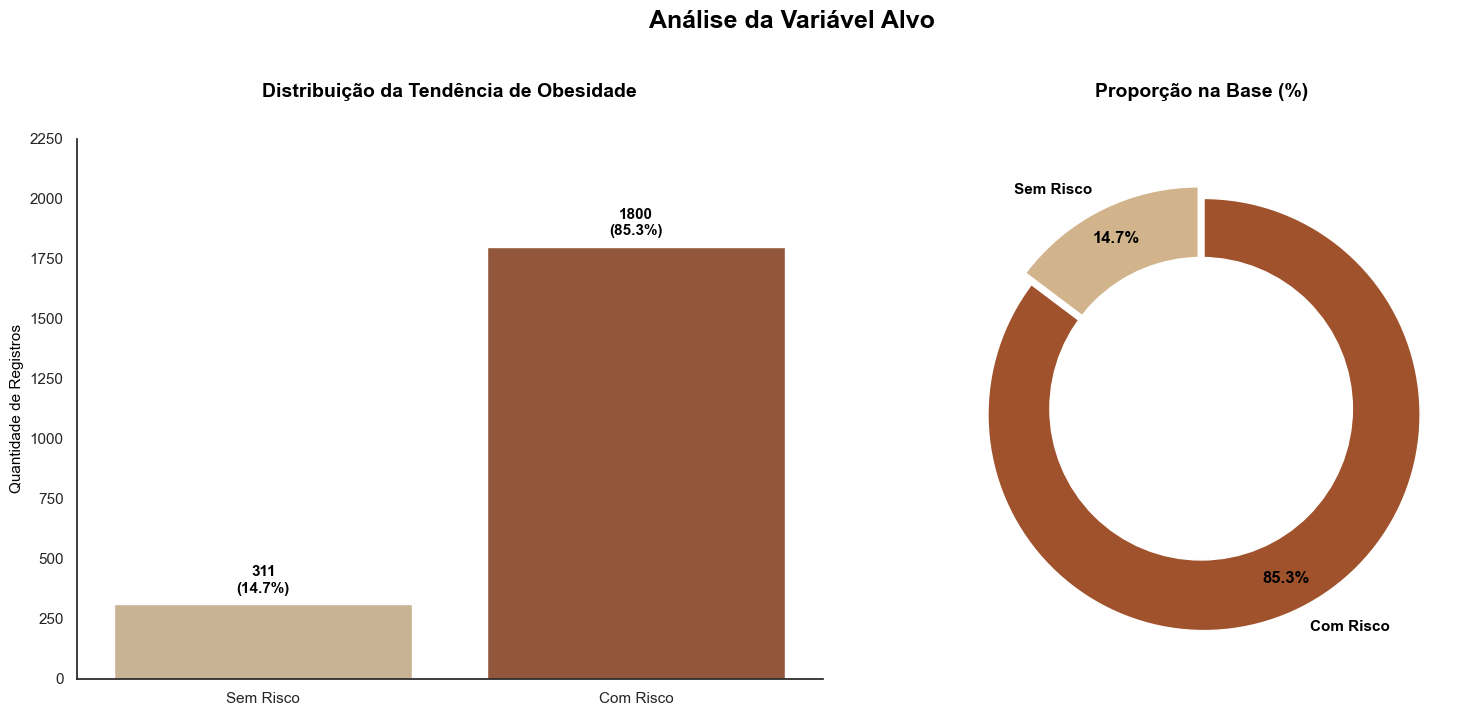

In [17]:
contagem = df_base['tendencia_obesidade'].value_counts().sort_index()
labels = ['Sem Risco', 'Com Risco']
cores_alvo = [cor_tan, cor_sienna] 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- GRÁFICO 1: BARRAS COM AJUSTE DE ESPAÇO ---
sns.barplot(x=labels, y=contagem.values, palette=cores_alvo, ax=ax1, hue=labels, legend=False)

# 1. Ajuste dinâmico do texto: usamos 2% do valor máximo como respiro
espacamento = max(contagem.values) * 0.02

for i, v in enumerate(contagem.values):
    pct = (v / len(df_base)) * 100
    ax1.text(i, v + espacamento, f'{v}\n({pct:.1f}%)', 
             ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

# 2. Aumentamos o limite do eixo Y em 25% para criar "teto" para o texto
ax1.set_ylim(0, max(contagem.values) * 1.25)

# 3. Adicionamos 'pad=30' para empurrar o título para cima
ax1.set_title('Distribuição da Tendência de Obesidade', fontsize=14, fontweight='bold', pad=30)
ax1.set_ylabel('Quantidade de Registros', fontsize=11, color='black')
sns.despine(ax=ax1)

# --- GRÁFICO 2: ROSCA (DONUT) ---
ax2.pie(contagem, labels=labels, autopct='%1.1f%%', startangle=90, colors=cores_alvo, 
        pctdistance=0.85, explode=(0.03, 0.03), textprops={'fontweight': 'bold', 'color': 'black'})
ax2.add_artist(plt.Circle((0,0), 0.70, fc='white'))

# Pad=30 também aqui para manter simetria
ax2.set_title('Proporção na Base (%)', fontsize=14, fontweight='bold', pad=30)

plt.suptitle('Análise da Variável Alvo', fontsize=18, fontweight='bold', color='black', y=1.02)
plt.tight_layout()
plt.show()

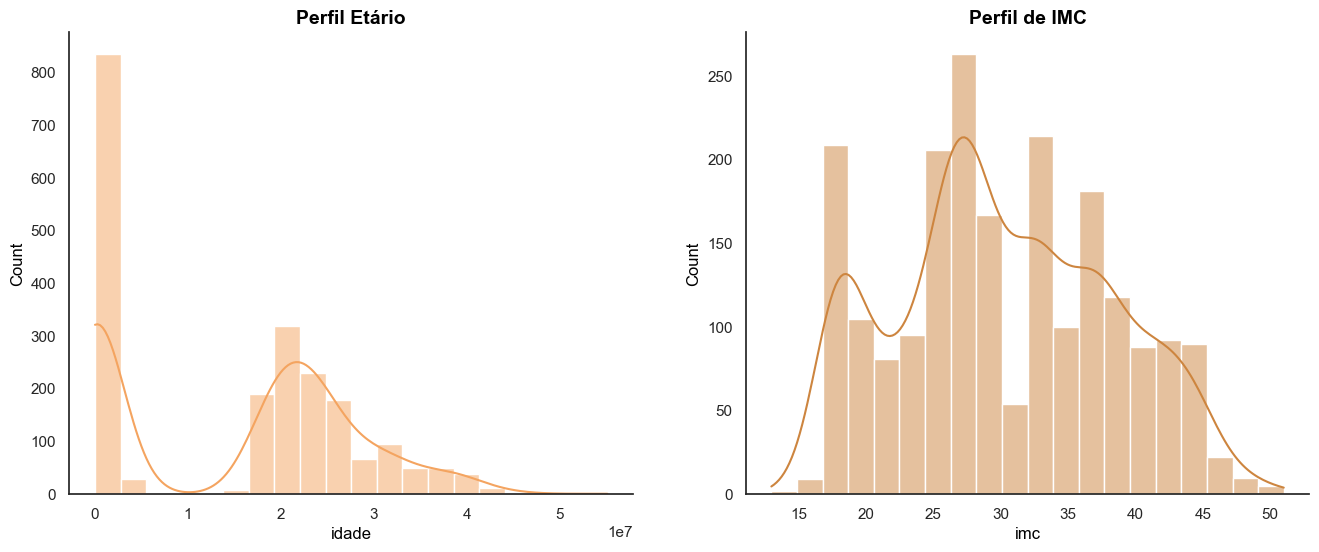

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Idade usando Sandy Brown
sns.histplot(df_base['idade'], bins=20, kde=True, ax=ax1, color=cor_sand, edgecolor='white')
ax1.set_title('Perfil Etário', fontsize=14, fontweight='bold')

# IMC usando Peru (Ocre)
sns.histplot(df_base['imc'], bins=20, kde=True, ax=ax2, color=cor_peru, edgecolor='white')
ax2.set_title('Perfil de IMC', fontsize=14, fontweight='bold')

sns.despine()
plt.show()

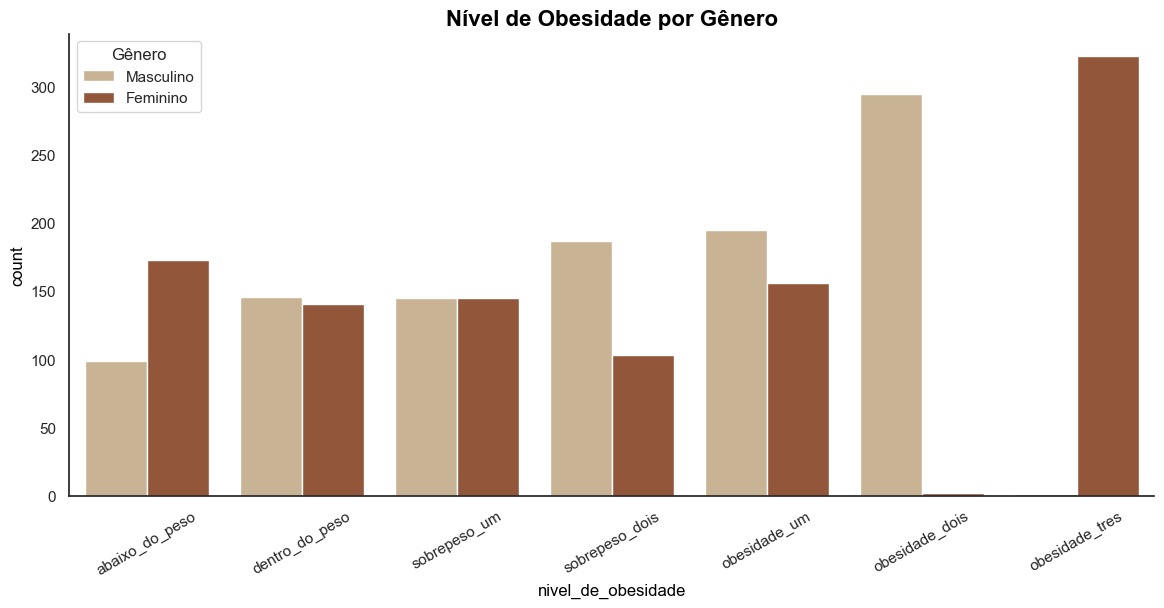

In [19]:
ordem_obesidade = ['abaixo_do_peso', 'dentro_do_peso', 'sobrepeso_um', 'sobrepeso_dois', 'obesidade_um', 'obesidade_dois', 'obesidade_tres']

plt.figure(figsize=(14, 6))
sns.countplot(data=df_base, x='nivel_de_obesidade', hue='genero', order=ordem_obesidade, palette=[cor_tan, cor_sienna])

plt.title('Nível de Obesidade por Gênero', fontsize=16, fontweight='bold')
plt.xticks(rotation=30)
plt.legend(title='Gênero', labels=['Masculino', 'Feminino'])
sns.despine()
plt.show()

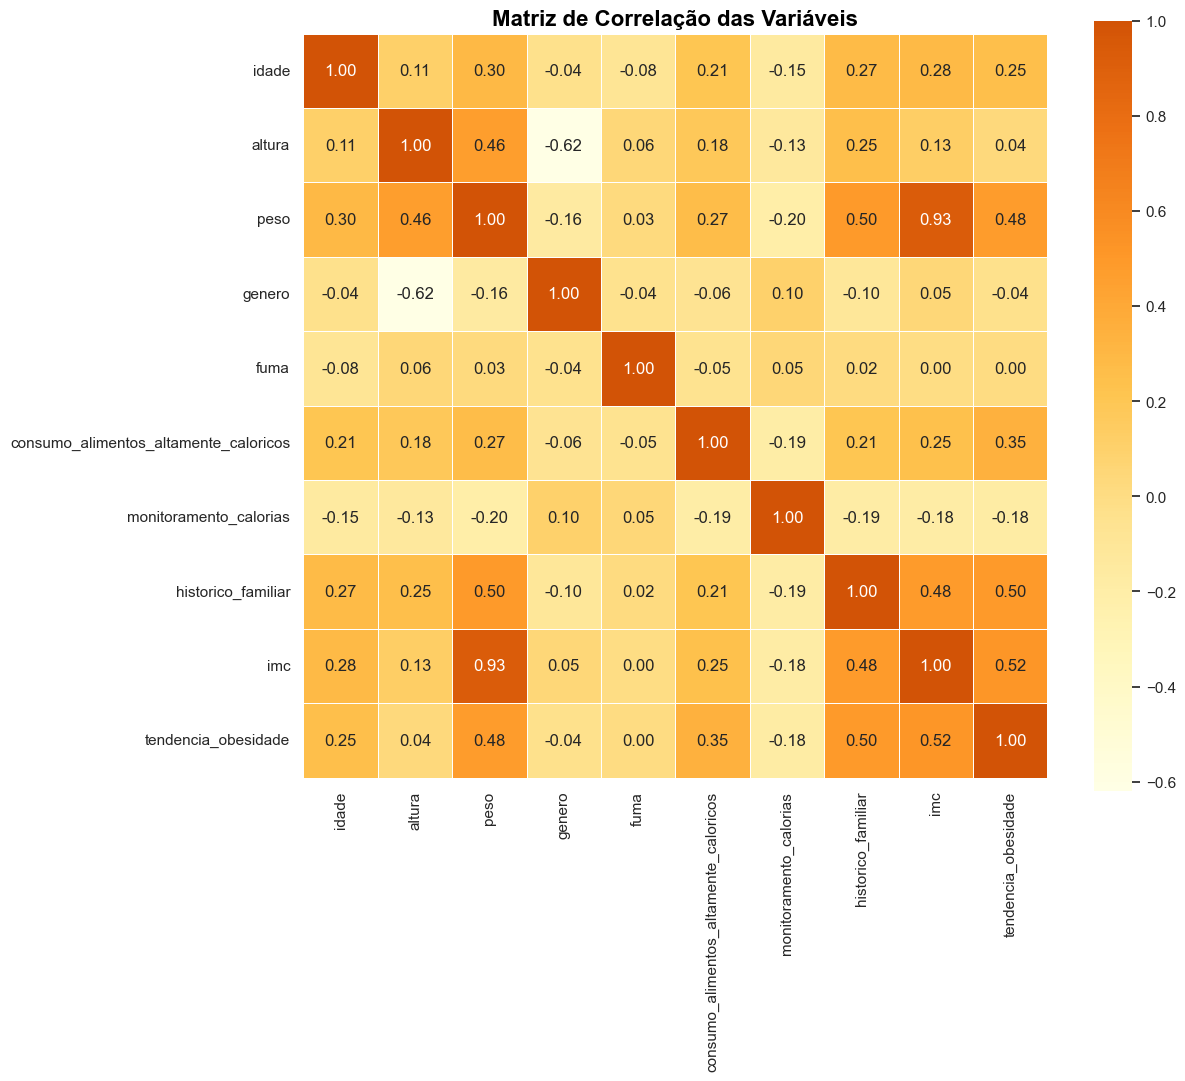

In [20]:
df_numeric = df_base.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
# Usando o mapa 'YlOrBr' que combina perfeitamente com Tan e Sienna
sns.heatmap(df_numeric.corr(), annot=True, fmt=".2f", cmap='YlOrBr', center=0.5, square=True, linewidths=.5)

plt.title('Matriz de Correlação das Variáveis', fontsize=16, fontweight='bold')
plt.show()

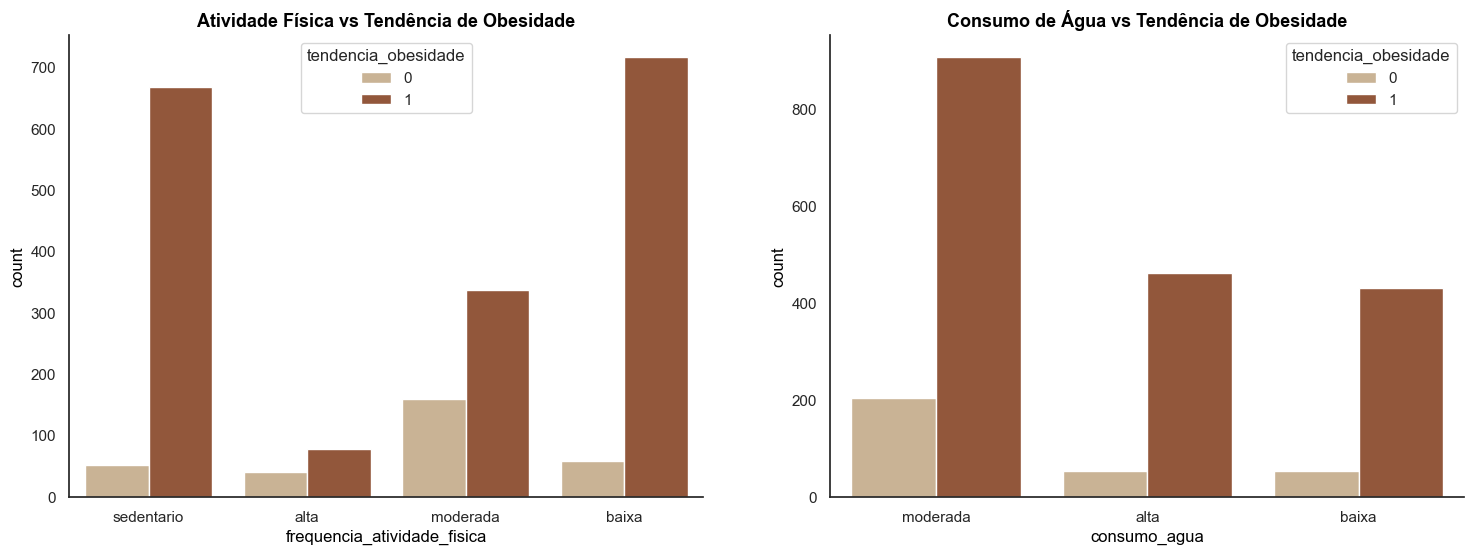

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Atividade Física
sns.countplot(data=df_base, x='frequencia_atividade_fisica', hue='tendencia_obesidade', ax=ax[0], palette=cores_alvo)
ax[0].set_title('Atividade Física vs Tendência de Obesidade', fontsize=13, fontweight='bold')

# Consumo de Água
sns.countplot(data=df_base, x='consumo_agua', hue='tendencia_obesidade', ax=ax[1], palette=cores_alvo)
ax[1].set_title('Consumo de Água vs Tendência de Obesidade', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

## Aplicação dos modelos

In [18]:
# Exclui colunas target
df_base_modelo = df_base.drop(['peso', 'altura','nivel_de_obesidade','imc'], axis=1)
df_base_modelo.head()

,idade,genero,consumo_refeicoes_principais,consumo_vegetais,consumo_agua,frequencia_atividade_fisica,tempo_uso_tecnologia,fuma,consumo_alimentos_altamente_caloricos,monitoramento_calorias,historico_familiar,consumo_lanches_entre_refeicoes,consumo_alcool,meio_de_transporte,tendencia_obesidade
0,21,1,tres_refeicoes_por_dia,as_vezes,moderada,sedentario,moderada,0,0,0,1,baixa,nunca,transporte_publico,0
1,21,1,tres_refeicoes_por_dia,sempre,alta,alta,baixa,1,0,1,1,baixa,baixa,transporte_publico,0
2,23,0,tres_refeicoes_por_dia,as_vezes,moderada,moderada,moderada,0,0,0,1,baixa,moderada,transporte_publico,0
3,27,0,tres_refeicoes_por_dia,sempre,moderada,moderada,baixa,0,0,0,0,baixa,moderada,caminhada,0
4,22,0,uma_refeicao_por_dia,as_vezes,moderada,sedentario,baixa,0,0,0,0,baixa,baixa,transporte_publico,0


In [19]:
# Definindo colunas
features_categoricas = ['genero', 'consumo_refeicoes_principais', 'consumo_vegetais', 
                       'consumo_agua', 'frequencia_atividade_fisica', 'tempo_uso_tecnologia',
                       'consumo_alcool', 'meio_de_transporte', 'consumo_lanches_entre_refeicoes']
features_numericas = ['idade', 'fuma', 'consumo_alimentos_altamente_caloricos', 'monitoramento_calorias',
                      'historico_familiar']

# Preprocessamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_categoricas)
    ])

In [28]:
# 1. Preparação dos dados fora da função
X = df_base_modelo.drop('tendencia_obesidade', axis=1)
y = df_base_modelo['tendencia_obesidade']

# Split da base com stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# 3. Execução Final
df_ranking, pipes = treinar_e_avaliar_modelos(X_train, X_test, y_train, y_test, preprocessor)

# Exibição dos resultados
print("\nRANKING FINAL DE MODELOS:")
print(df_ranking.to_string(index=False))


RANKING FINAL DE MODELOS:
             Modelo  Acurácia  Precisão   Recall  F1-score  AUC-ROC Overfit (%)
            XGBoost  0.955083  0.956710 0.960870  0.958785 0.990876       4.37%
      Random Forest  0.952719  0.972973 0.939130  0.955752 0.990415       4.49%
Logistic Regression  0.914894  0.925439 0.917391  0.921397 0.954697       0.93%


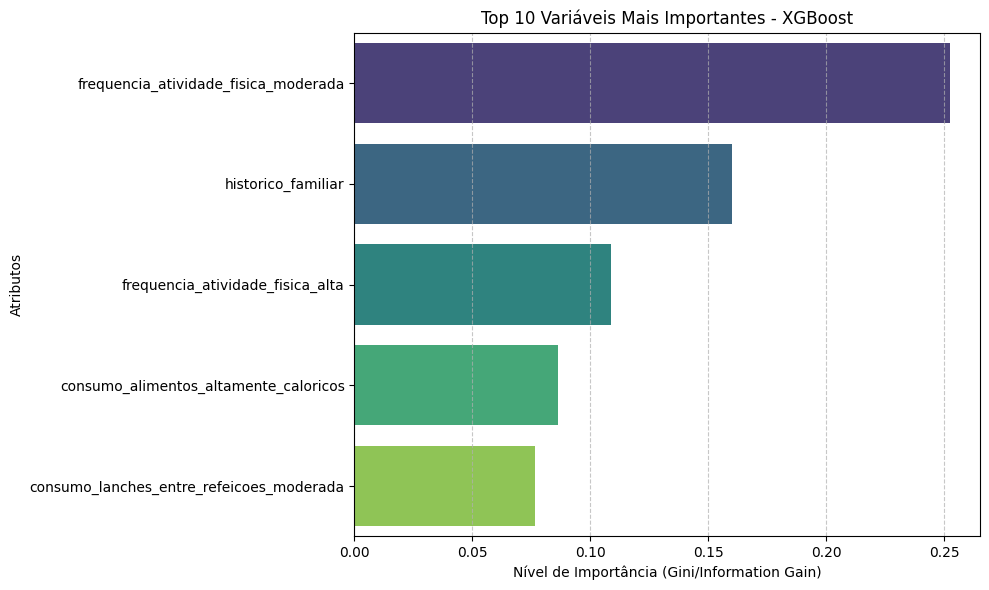

In [ ]:
## Variáveis mais importantes (Top 5)
plot_importancia_xgboost(pipes["XGBoost"])

In [32]:
# 1. Definir a estrutura de pastas para o modelo
diretorio_pai = Path.cwd().parent
# Criaremos uma pasta chamada 'models' dentro do seu projeto
pasta_modelos = diretorio_pai / 'fiap_tech_challenge_fase_4' / 'models'

# 2. Criar a pasta se não existir
pasta_modelos.mkdir(parents=True, exist_ok=True)

# 3. Definir o nome do arquivo (ex: melhor_modelo_xgb.joblib)
nome_modelo = 'modelo_final_xgboost.joblib'
caminho_modelo = pasta_modelos / nome_modelo

# 4. Salvar o PIPELINE completo
# Importante: Salvamos o 'pipe' porque ele já contém o preprocessor + o modelo treinado
vencedor = df_ranking.iloc[0]['Modelo'] # Pega o nome do vencedor do seu ranking
melhor_pipe = pipes[vencedor]

joblib.dump(melhor_pipe, caminho_modelo)

print("-" * 30)
print(f"✅ Modelo salvo com sucesso!")
print(f"📁 Pasta: 'fiap_tech_challenge_fase_4'/ 'models'")
print(f"📄 Arquivo: {nome_modelo}")
print("-" * 30)

------------------------------
✅ Modelo salvo com sucesso!
📁 Pasta: 'fiap_tech_challenge_fase_4'/ 'models'
📄 Arquivo: modelo_final_xgboost.joblib
------------------------------
